In [187]:
from transformers import CLIPTokenizer, CLIPModel
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [188]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [189]:
samples = ['abstract', 'cow']

text_inputs = tokenizer(samples, padding='max_length', return_tensors="pt", max_length=10)

model.get_text_features(**text_inputs.to(device)).shape


torch.Size([2, 512])

In [219]:
from transformers import CLIPTextModelWithProjection, CLIPTextConfig

class CLIPForRegression(CLIPTextModelWithProjection):
    def __init__(self, config: CLIPTextConfig):
        super().__init__(config)
        self.regressor = torch.nn.Linear(config.hidden_size, 1)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, **kwargs):
        outputs = super().forward(**kwargs)
        outputs = self.dropout(outputs.text_embeds)
        outputs = self.regressor(outputs)
        return outputs

In [192]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/conreteness_ratings')
ds = ds.rename_column('Conc.M', 'avg_concreteness')

from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset 

scaler = MinMaxScaler()

processing_ds = ds['train'].to_pandas()

processing_ds['avg_concreteness'] = scaler.fit_transform(processing_ds['avg_concreteness'].to_numpy().reshape(-1, 1))

ds['train'] = Dataset.from_pandas(processing_ds)


ds = ds.remove_columns(['Conc.SD', 'Unknown', 'Total', 'SUBTLEX', 'Percent_known', 'Bigram'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [210]:
def tokenize(batch):
    return tokenizer(batch['Word'], padding='max_length', return_tensors="pt", max_length=10)

ds = ds.filter(lambda x: x['Word'] is not None)

Filter:   0%|          | 0/39953 [00:00<?, ? examples/s]

In [194]:
tokenized_ds = ds.map(tokenize, batched=True)
tokenized_ds = tokenized_ds.rename_column('avg_concreteness', 'labels')
tokenized_ds = tokenized_ds['train'].train_test_split(test_size=0.1, shuffle=True)
tokenized_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/39953 [00:00<?, ? examples/s]

In [211]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_ds['train'], batch_size=8)
test_loader = DataLoader(tokenized_ds['test'], batch_size=8)

In [220]:
model = CLIPForRegression.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPForRegression: ['vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.11.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision_model.encoder.layers.2.mlp.fc1.bias', 'vision_model.encoder.layers.7.mlp.fc1.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.weight', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.en

CLIPForRegression(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [221]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=2e-5)

In [222]:
from transformers import get_scheduler

num_epochs = 4
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(name='linear',optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [223]:
import torch
loss_fn = torch.nn.MSELoss()

In [224]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
losses = []

model.train()
for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = loss_fn(outputs, batch['labels'].unsqueeze(-1)) 
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/17980 [00:00<?, ?it/s]

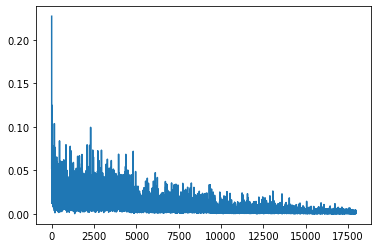

In [225]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [226]:
from scipy.stats import pearsonr

model.eval()

predictions = []
targets = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
    predictions.extend(outputs.squeeze().tolist())
    targets.extend(batch["labels"].squeeze().tolist())



corr_corf, p_value = pearsonr(predictions, targets)

print(f"Pearson Correlation Coefficient: {corr_corf:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.9007
P-value: 0.0000


In [203]:
def predict(word):
    with torch.no_grad():
        outputs = model(**tokenizer(word, padding='max_length', return_tensors="pt", max_length=10).to(device))
    return outputs.item()

In [228]:
predict('dog'), predict('abstract'), predict('cow')

(0.9851014614105225, 0.18514317274093628, 0.9905253648757935)

In [229]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [231]:
model.push_to_hub('martingrzzler/clip-word-concreteness', create_pr=1)

CommitInfo(commit_url='https://huggingface.co/martingrzzler/clip-word-concreteness/commit/6f7263d205136f76fb590eb5fc97ac74fa1271cb', commit_message='Upload CLIPForRegression', commit_description='', oid='6f7263d205136f76fb590eb5fc97ac74fa1271cb', pr_url='https://huggingface.co/martingrzzler/clip-word-concreteness/discussions/1', pr_revision='refs/pr/1', pr_num=1)